In [26]:
%pip install dask-expr -q

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import numpy as np
import geopandas as gpd
import rasterio

import spyndex

import xarray as xr

import dask.distributed
from rasterio.enums import Resampling

from IPython.display import display
from pystac_client import Client
from odc.stac import configure_rio, stac_load

Make ntoes here about using stac from element 84 instead of DEA but both are part of AWS open data repo

In [28]:
stac_url_sentinel = "https://earth-search.aws.element84.com/v1/"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-04-01"
end_date = "2024-05-01"

resolution = 10

crs = 3857

In [29]:
# imprort tes area as shapefile
gdf = gpd.read_file('/workspaces/collecting-raster-data-notebooks/notebooks/data/aoi/aoi.shp').to_crs("EPSG:4326")

bbox = list(gdf.total_bounds)

In [30]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

display(client)

/usr/local/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41741 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41741/status,
Dashboard: http://127.0.0.1:41741/status,Workers: 5
Total threads: 20,Total memory: 31.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42701,Workers: 5
Dashboard: http://127.0.0.1:41741/status,Total threads: 20
Started: Just now,Total memory: 31.26 GiB
Comm: tcp://127.0.0.1:38903,Total threads: 4
Dashboard: http://127.0.0.1:44565/status,Memory: 6.25 GiB
Nanny: tcp://127.0.0.1:40449,


In [31]:
catalog = Client.open(stac_url_sentinel)

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox
)



In [32]:
items = list(query.items())
print(f"Found {len(items):d} datasets")

#convert the fetched stac items to a geojson featurecollection
stac_json = query.item_collection_as_dict()

Found 12 datasets


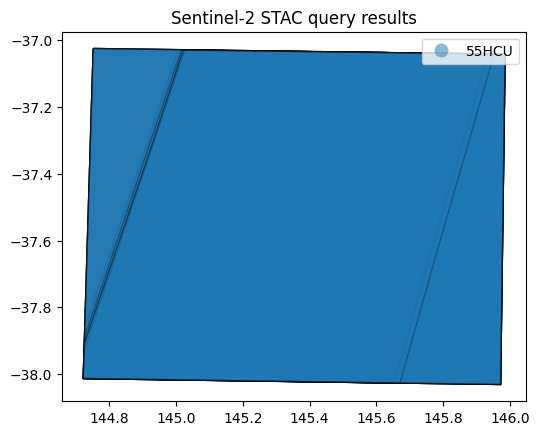

In [33]:
gdf = gpd.GeoDataFrame.from_features(stac_json, f"epsg:{crs}")

# compute granule id from components
gdf["granule"]= (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot("granule",
               edgecolor="black",
               alpha=0.5,
               categorical=True,
               aspect="equal",
               legend=True)

_=fig.set_title("Sentinel-2 STAC query results")

In [34]:

#lazily combine
xx = stac_load(
    items,
    bands = ("red", "green", "blue", "nir", "scl"),
    #crs=f"epsg:{crs}",
    resolution = resolution,
    chunks={}, # use dask
    groupby = "solar_day", #this merges adjacent scenes and de-duplicates overlapping pixels
    bbox = bbox,
    resampling="bilinear"
)

# data is not loaded yet
display(xx)

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 541, x: 539, time: 12)
Coordinates:
  * y            (y) float64 4kB 5.832e+06 5.832e+06 ... 5.826e+06 5.826e+06
  * x            (x) float64 4kB 3.477e+05 3.477e+05 ... 3.531e+05 3.531e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 96B 2024-04-01T00:17:21.020000 ... 202...
Data variables:
    red          (time, y, x) uint16 7MB dask.array<chunksize=(1, 541, 539), meta=np.ndarray>
    green        (time, y, x) uint16 7MB dask.array<chunksize=(1, 541, 539), meta=np.ndarray>
    blue         (time, y, x) uint16 7MB dask.array<chunksize=(1, 541, 539), meta=np.ndarray>
    nir          (time, y, x) uint16 7MB dask.array<chunksize=(1, 541, 539), meta=np.ndarray>
    scl          (time, y, x) uint8 3MB dask.array<chunksize=(1, 541, 539), meta=np.ndarray>

In [35]:
%%time

xx = xx.load()    

CPU times: user 4.91 s, sys: 967 ms, total: 5.88 s
Wall time: 1min 19s


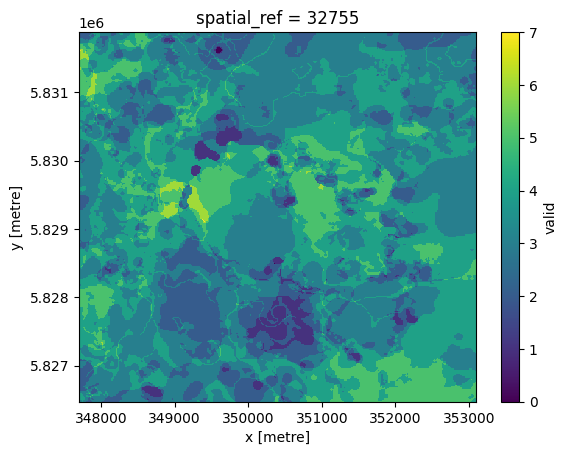

In [36]:
# define a mask for valid pixels (non-cloud)

def is_valid_pixel(data):
    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

xx['valid'] = is_valid_pixel(xx.scl)
xx.valid.sum("time").plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


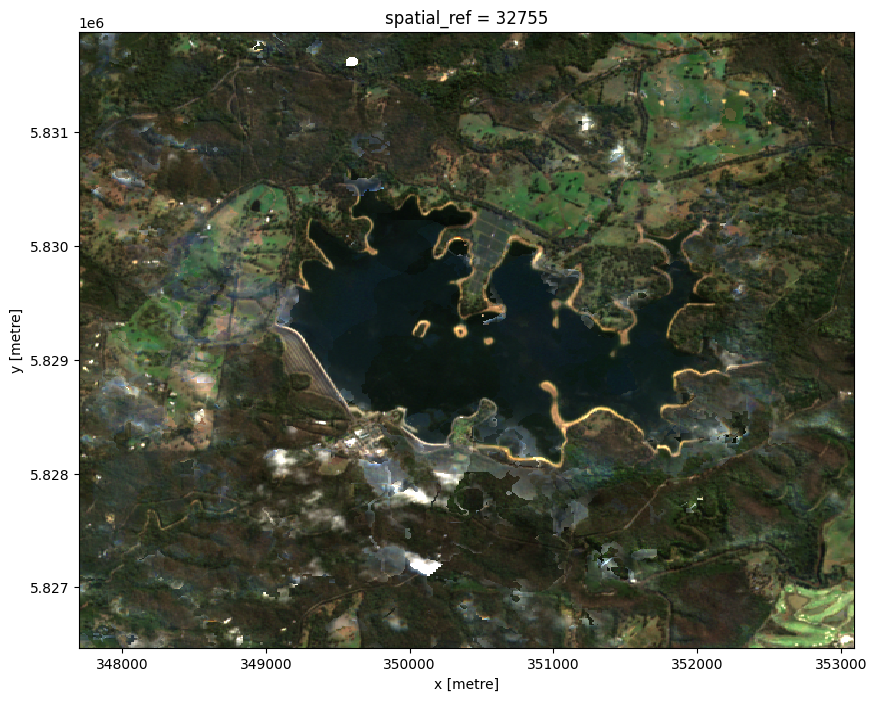

In [37]:
# compute the masked median
rgb_median = (
    xx[['red', 'green', 'blue']]
    .where(xx.valid)
    .to_dataarray(dim="band")
    .transpose(..., "band")
    .median(dim="time")
)
(rgb_median / rgb_median.max() * 2).plot.imshow(rgb="band", figsize=(10, 8))

In [38]:
# band data is in uint16, convert to float32 rough and quick:

xx = xx/10000

xx

<xarray.Dataset> Size: 168MB
Dimensions:      (y: 541, x: 539, time: 12)
Coordinates:
  * y            (y) float64 4kB 5.832e+06 5.832e+06 ... 5.826e+06 5.826e+06
  * x            (x) float64 4kB 3.477e+05 3.477e+05 ... 3.531e+05 3.531e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 96B 2024-04-01T00:17:21.020000 ... 202...
Data variables:
    red          (time, y, x) float64 28MB 0.4628 0.46 0.4584 ... 0.0542 0.0572
    green        (time, y, x) float64 28MB 0.4644 0.4628 ... 0.0512 0.0482
    blue         (time, y, x) float64 28MB 0.4912 0.482 0.4768 ... 0.0451 0.0427
    nir          (time, y, x) float64 28MB 0.5552 0.5528 0.554 ... 0.107 0.0962
    scl          (time, y, x) float64 28MB 0.0009 0.0009 ... 0.0005 0.0005
    valid        (time, y, x) float64 28MB 0.0 0.0 0.0 ... 0.0001 0.0001 0.0001

In [39]:
def calc_ndvi(data):
    return (data.nir - data.red) / (data.nir + data.red)


xx['ndvi'] = calc_ndvi(xx)

In [40]:
xx

<xarray.Dataset> Size: 196MB
Dimensions:      (y: 541, x: 539, time: 12)
Coordinates:
  * y            (y) float64 4kB 5.832e+06 5.832e+06 ... 5.826e+06 5.826e+06
  * x            (x) float64 4kB 3.477e+05 3.477e+05 ... 3.531e+05 3.531e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 96B 2024-04-01T00:17:21.020000 ... 202...
Data variables:
    red          (time, y, x) float64 28MB 0.4628 0.46 0.4584 ... 0.0542 0.0572
    green        (time, y, x) float64 28MB 0.4644 0.4628 ... 0.0512 0.0482
    blue         (time, y, x) float64 28MB 0.4912 0.482 0.4768 ... 0.0451 0.0427
    nir          (time, y, x) float64 28MB 0.5552 0.5528 0.554 ... 0.107 0.0962
    scl          (time, y, x) float64 28MB 0.0009 0.0009 ... 0.0005 0.0005
    valid        (time, y, x) float64 28MB 0.0 0.0 0.0 ... 0.0001 0.0001 0.0001
    ndvi         (time, y, x) float64 28MB 0.09077 0.09163 ... 0.3275 0.2542

In [41]:
%pip install matplotlib -q
%pip install cartopy -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

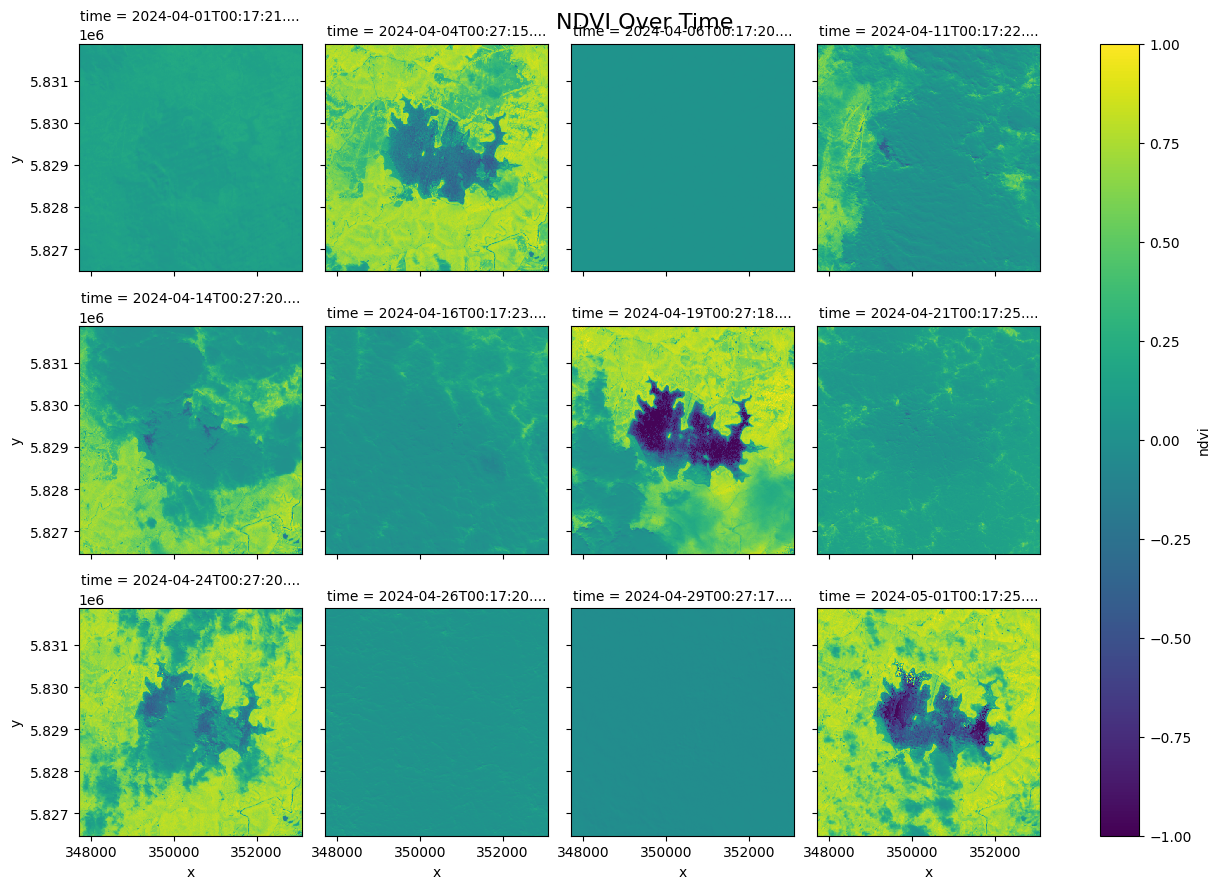

In [43]:
p = xx['ndvi'].plot(x='x', y='y', col='time', col_wrap=4, vmin=-1, vmax=1, cmap='viridis')

# Add overall title and adjust spacing
p.fig.suptitle('NDVI Over Time', fontsize=16)

plt.show()